In [1]:
import pandas as pd # standard
import numpy as np # standard
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score # for accuracy calculation
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

import thermogram_utilities

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("/Users/avery/OneDrive/Documents/GitHub/Clinical_TLB_2023-2024/lung_cancer_tlb.xlsx")

# replace NA with control
df['CancerType'] = np.where(df['CancerType'].isna(), 'Control', df['CancerType'])

# get location of cut off values
lower_column_index = df.columns.get_loc("T51")
upper_column_index = df.columns.get_loc("T83.1")
label_column_index = df.columns.get_loc("CancerType")

column_indices = np.arange(lower_column_index, upper_column_index)
column_indices = np.append(column_indices, 0)
column_indices = np.append(column_indices, 1)



column_indices = np.append(column_indices, label_column_index)

df = df.iloc[:, column_indices]

# keep only Control and Adenocarcinoma for analysis
df_tree = df[(df['CancerType'] == 'Control') | (df['CancerType'] == 'Adenocarcinoma')]
df_tree = df_tree.reset_index(drop=True)

In [3]:
feature_df = pd.read_excel("mean_feature_importance.xlsx")

sorted_feature_importance = feature_df.sort_values(by='Mean Importance', ascending=False)
rows_retained = round(len(sorted_feature_importance) * 0.25)

selected_temp = sorted_feature_importance.iloc[:rows_retained, :]

# Add 'T' to the beginning of each element in the 'Temperature' column
selected_temps = 'T' + selected_temp['Temperature'].astype(str)
selected_temps = selected_temps.str.replace(".0", '')


top_features_df = pd.concat([df_tree[selected_temps], df_tree[["sample_id", "pub_id", "CancerType"]]], axis = 1)

df_tree_1 = df_tree

df_tree = top_features_df

Visualize the feature importance

In [4]:
df_long = pd.melt(df_tree_1, id_vars=['sample_id', 'pub_id', 'CancerType'], var_name='temp', value_name='dsp' )

median_df = thermogram_utilities.median_curve(df_long, 'CancerType', 'temp', 'dsp')

median_df['temperature'] = median_df['temperature'].str.replace('T', '').astype(float)




Text(0.5, 1.0, 'Temperature and Importance')

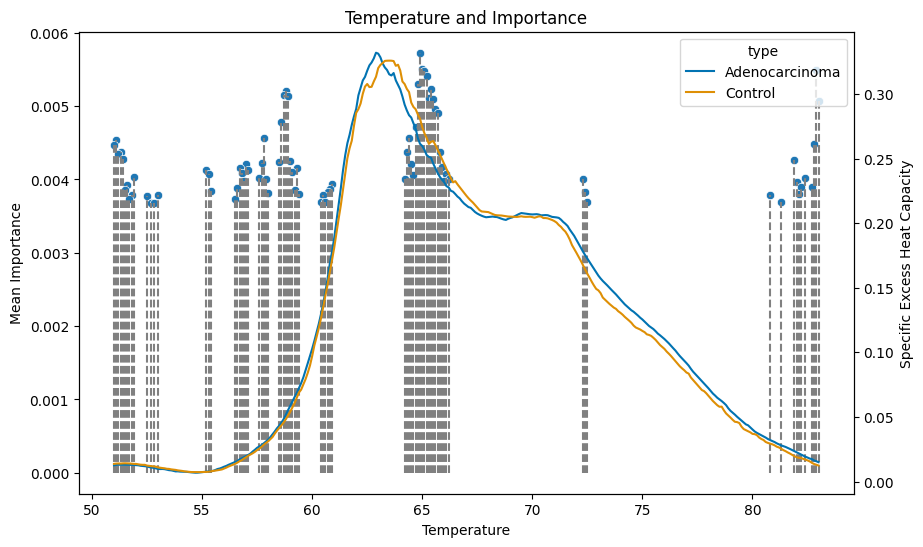

In [5]:
plt.figure(figsize=(10, 6))

# create a  plot
sns.scatterplot(data=selected_temp, x='Temperature', y="Mean Importance")

for index, row in selected_temp.iterrows():
    x_value = row['Temperature']
    y_value = row["Mean Importance"]
    
    # Add a vertical line from the point to the x-axis
    plt.plot([x_value, x_value], [0, y_value], color='gray', linestyle='--')


ax2 = plt.gca().twinx()

p = sns.lineplot(data=median_df, x='temperature', y='median',ax=ax2, hue='type', palette='colorblind')


# add labels and title
plt.xlabel('Temperature')
plt.ylabel('Mean Importance')
ax2.set_ylabel('Specific Excess Heat Capacity')
plt.title('Temperature and Importance')

In [6]:
# set up for feature importance

#    create temps to append to df
temps = df_tree.drop(['CancerType', 'sample_id', 'pub_id'], axis = 1).columns.str.replace('T', '')
temps = temps.astype(float)

#    create df
feature_importance = pd.DataFrame({"Temperature":temps})

# create performace df: balanced accuracy, auc
performance_metrics = pd.DataFrame(columns=['Weighted Accuracy', 'AUC'])

# set number of bootstraps
total_bootstraps = 1000

# length of df
num_rows = df_tree.shape[0]

# create array of all indices in full data set
all_indices = np.arange(num_rows)

# columns to drop
drop_cols = ['sample_id', 'pub_id', 'CancerType']

# loop for specified iterations
for i in range(total_bootstraps):
    
    # randomly select indices to use as train set
    train_indices = np.random.choice(num_rows, num_rows, replace = True)

    # get the train set using the indices
    train_set = df_tree.iloc[train_indices, : ]

    # get indices not included in train_indices to use as test set
    test_indices = np.setdiff1d(all_indices, train_indices)

    # get test set using test indices
    test_set = df_tree.iloc[test_indices, :]

    # initialize random forest (default settings)
    clf = RandomForestClassifier()

    # train forest
    clf = clf.fit(train_set.drop(drop_cols, axis = 1), train_set['CancerType'])

    # get probabilities
    test_probabilities = clf.predict_proba(test_set.drop(drop_cols, axis = 1))

    # test decision tree
    test_predictions = clf.predict(test_set.drop(drop_cols, axis = 1))

    # calculate weighted accuracy
    balanced_acc = balanced_accuracy_score(test_set['CancerType'], test_predictions)

    # calculate AUC
    auc = roc_auc_score(test_set['CancerType'] == 'Control', test_probabilities[:, 1])

    # append accuracy, auc to results df
    performance_metrics.loc[len(performance_metrics)] = [balanced_acc, auc]

    feature_importance[i] = clf.feature_importances_

{0.5999033298699389} {0.6527588377959297}


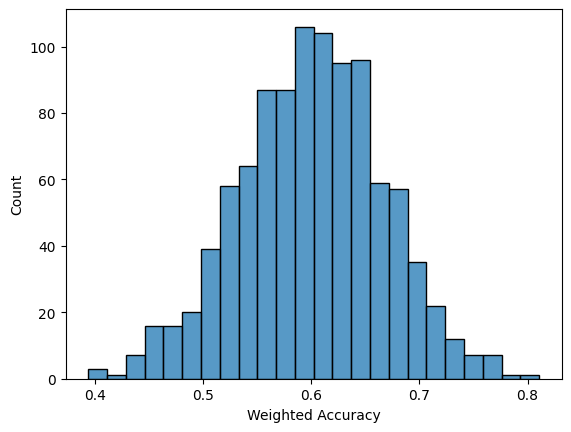

In [7]:
sns.histplot(data=performance_metrics['Weighted Accuracy'])
print({performance_metrics['Weighted Accuracy'].mean()}, {performance_metrics['AUC'].mean()})

<Axes: >

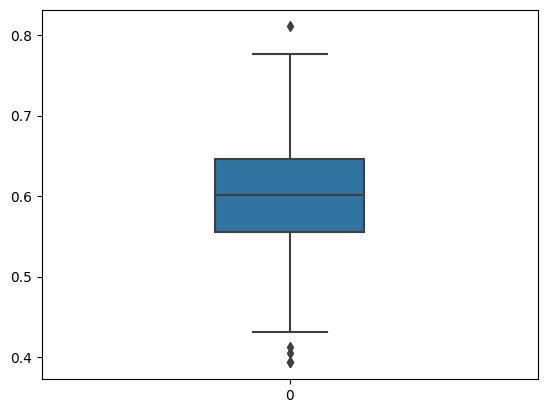

In [8]:
sns.boxplot(data=performance_metrics['Weighted Accuracy'], width=0.3)

# Add points to the boxplot using the swarmplot function
#sns.swarmplot(data=performance_metrics['Weighted Accuracy'], color='red', size=8)